In [2]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import pmdarima as pm
from pmdarima.arima import auto_arima
from pylab import rcParams
import requests
import json

In [3]:
# with open("tingo_api.json", "r") as file:
#     tingo_api = json.load(file)
# api_key = tingo_api['api_key']

In [4]:
# headers = {
#     'Content-Type': 'application/json',
#     'Authorization': f'Token {api_key}'
# }
# url =  "https://api.tiingo.com/tiingo/daily/MSFT/prices?startDate=2017-06-13&endDate=2025-06-13&resampleFreq=1min"


# response = requests.get(url, headers=headers)
# data = response.json()

In [5]:
msft = yf.Ticker("MSFT")
msft_df = msft.history(
    period="max", 
    interval="1h",
)

print(msft_df.head())

                                 Open        High         Low       Close  \
Datetime                                                                    
2023-06-15 09:30:00-04:00  337.480011  344.802887  337.200012  344.459991   
2023-06-15 10:30:00-04:00  344.450012  345.756500  343.399994  345.089996   
2023-06-15 11:30:00-04:00  345.084991  346.779999  344.679993  346.268890   
2023-06-15 12:30:00-04:00  346.269989  346.619995  344.391388  345.269989   
2023-06-15 13:30:00-04:00  345.290009  347.200012  344.829987  346.804993   

                            Volume  Dividends  Stock Splits  
Datetime                                                     
2023-06-15 09:30:00-04:00  9254930        0.0           0.0  
2023-06-15 10:30:00-04:00  5245124        0.0           0.0  
2023-06-15 11:30:00-04:00  3209514        0.0           0.0  
2023-06-15 12:30:00-04:00  2754889        0.0           0.0  
2023-06-15 13:30:00-04:00  3567412        0.0           0.0  


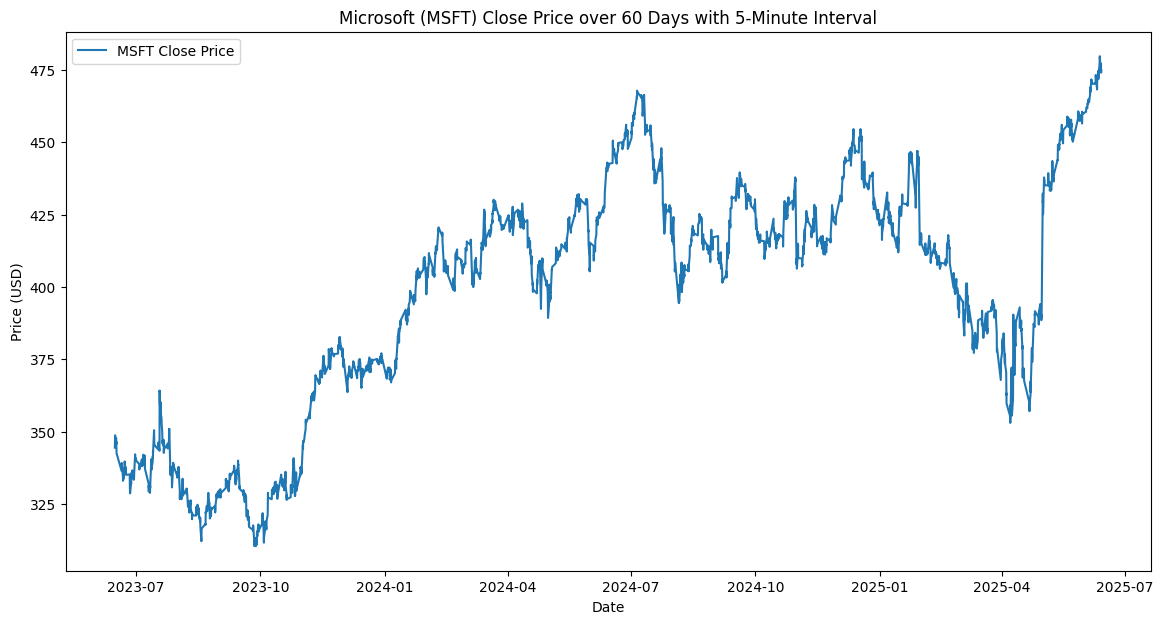

In [6]:
plt.figure(figsize=(14, 7))
plt.plot(msft_df.index, msft_df['Close'], label='MSFT Close Price')
plt.title('Microsoft (MSFT) Close Price over 60 Days with 5-Minute Interval')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend();

# Testing For Stationarity

Results of dickey fuller test
Test Statistics                  -1.381914
p-value                           0.590916
No. of lags used                  0.000000
Number of observations used    3486.000000
critical value (1%)              -3.432227
critical value (5%)              -2.862369
critical value (10%)             -2.567212
dtype: float64


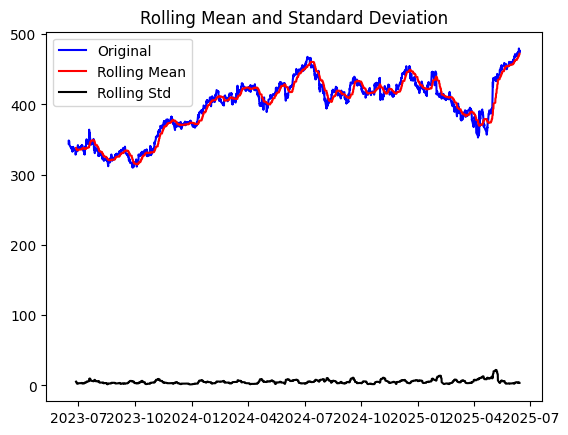

In [7]:

def test_stationarity(timeseries):
   
    rolmean = timeseries.rolling(50).mean()
    rolstd = timeseries.rolling(50).std()
 
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    print("Results of dickey fuller test")
    adft = adfuller(timeseries)
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
test_stationarity(msft_df['Close'])

Interpretation: 
* Null Hypothesis: The time series is non-stationary.
* Alternative Hypothesis: The time series is stationary.

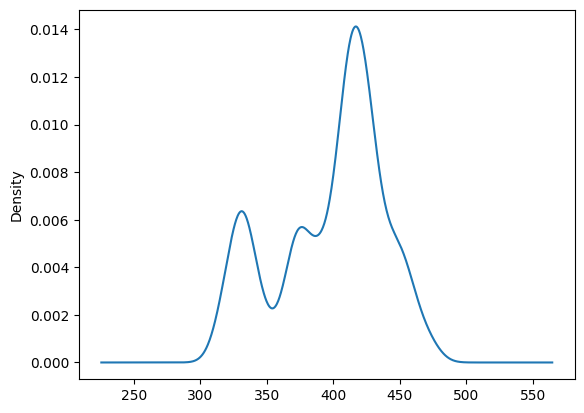

In [8]:
msft_df['Close'].plot(kind='kde');

<Figure size 640x480 with 0 Axes>

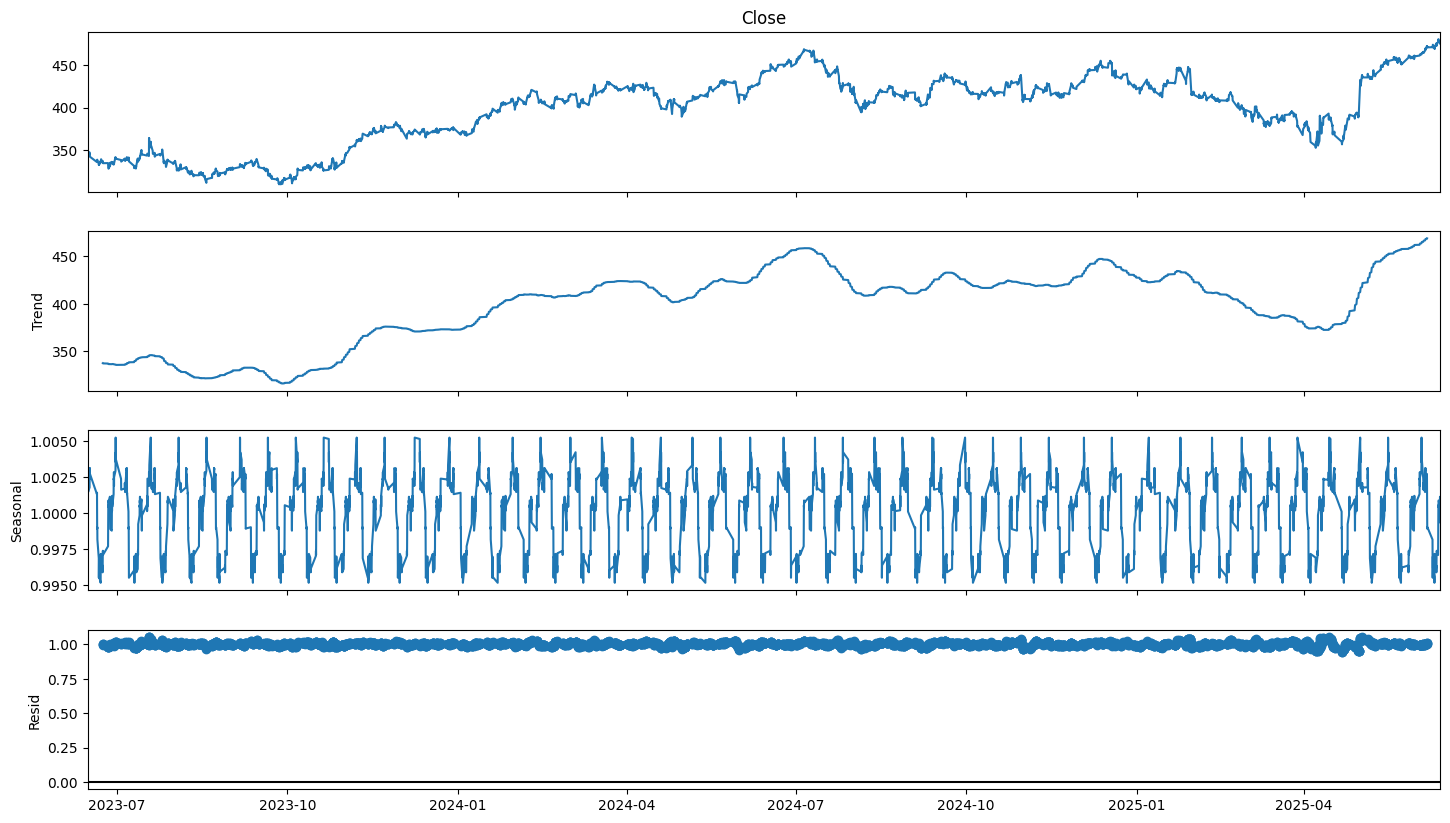

In [9]:
result = seasonal_decompose(msft_df['Close'], model='multiplicative', period = 78)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9);

# Reducing Trend

C:\Users\billy\AppData\Local\Temp\ipykernel_14572\3003609869.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='best')


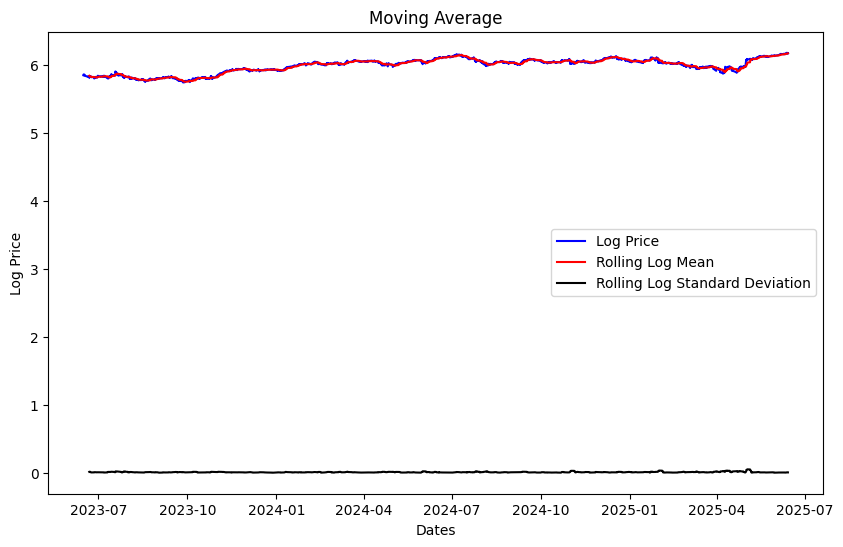

In [10]:
rcParams['figure.figsize'] = 10, 6
msft_df['Log_Close'] = np.log(msft_df['Close'])
msft_df['Rolling_Log_Avg'] = msft_df['Log_Close'].rolling(24).mean()
msft_df['Rolling_Log_Std'] = msft_df['Log_Close'].rolling(24).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(msft_df['Log_Close'], color='blue', label = 'Log Price')
plt.plot(msft_df['Rolling_Log_Avg'], color="red", label = "Rolling Log Mean")
plt.plot(msft_df['Rolling_Log_Std'], color = "black", label = "Rolling Log Standard Deviation")
plt.xlabel('Dates')
plt.ylabel('Log Price')
plt.legend()
plt.show()

# Train/Test 

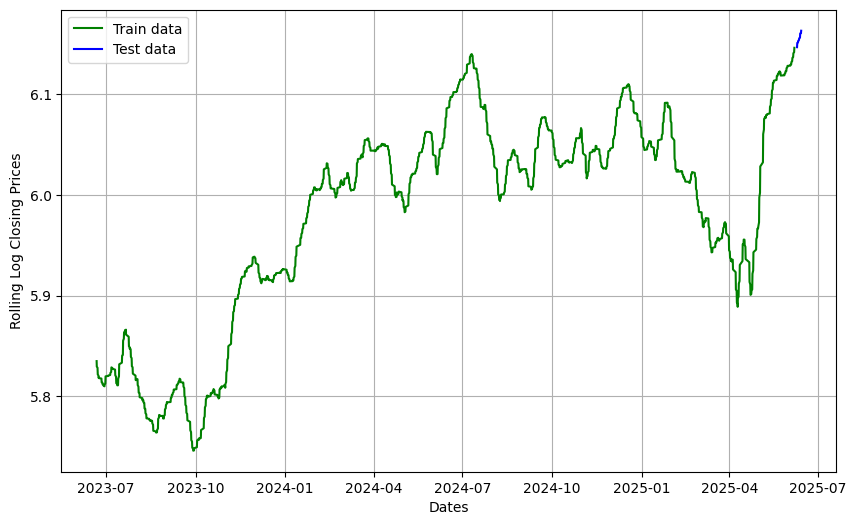

In [11]:
msft_df.dropna(inplace=True)
train_size = int(len(msft_df) * 0.99)
train_data, test_data =  msft_df['Rolling_Log_Avg'].iloc[:train_size], msft_df['Rolling_Log_Avg'].iloc[train_size:]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Rolling Log Closing Prices')
plt.plot(train_data, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend();

# HyperParameter Tuning: P, D, Q

c:\Users\billy\anaconda3\envs\stock_predictions\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\billy\anaconda3\envs\stock_predictions\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\billy\anaconda3\envs\stock_predictions\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\billy\anaconda3\envs\stock_predictions\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\billy\anaconda3\envs\stock_predictions\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: '

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-37226.855, Time=0.38 sec


c:\Users\billy\anaconda3\envs\stock_predictions\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-45104.114, Time=0.95 sec


c:\Users\billy\anaconda3\envs\stock_predictions\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-39998.884, Time=0.82 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-37203.738, Time=0.18 sec


c:\Users\billy\anaconda3\envs\stock_predictions\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\billy\anaconda3\envs\stock_predictions\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-45102.397, Time=1.46 sec


c:\Users\billy\anaconda3\envs\stock_predictions\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-45102.409, Time=1.86 sec


c:\Users\billy\anaconda3\envs\stock_predictions\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-37220.945, Time=2.34 sec


c:\Users\billy\anaconda3\envs\stock_predictions\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-45105.528, Time=0.33 sec


c:\Users\billy\anaconda3\envs\stock_predictions\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-45103.800, Time=0.32 sec


c:\Users\billy\anaconda3\envs\stock_predictions\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-45103.811, Time=0.60 sec


c:\Users\billy\anaconda3\envs\stock_predictions\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-40009.446, Time=0.33 sec


c:\Users\billy\anaconda3\envs\stock_predictions\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-44922.132, Time=1.52 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 11.161 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3429
Model:               SARIMAX(1, 1, 0)   Log Likelihood               22554.764
Date:                Fri, 13 Jun 2025   AIC                         -45105.528
Time:                        23:08:01   BIC                         -45093.248
Sample:                             0   HQIC                        -45101.141
                               - 3429                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9487      0.004    224.357      0.000       0.9

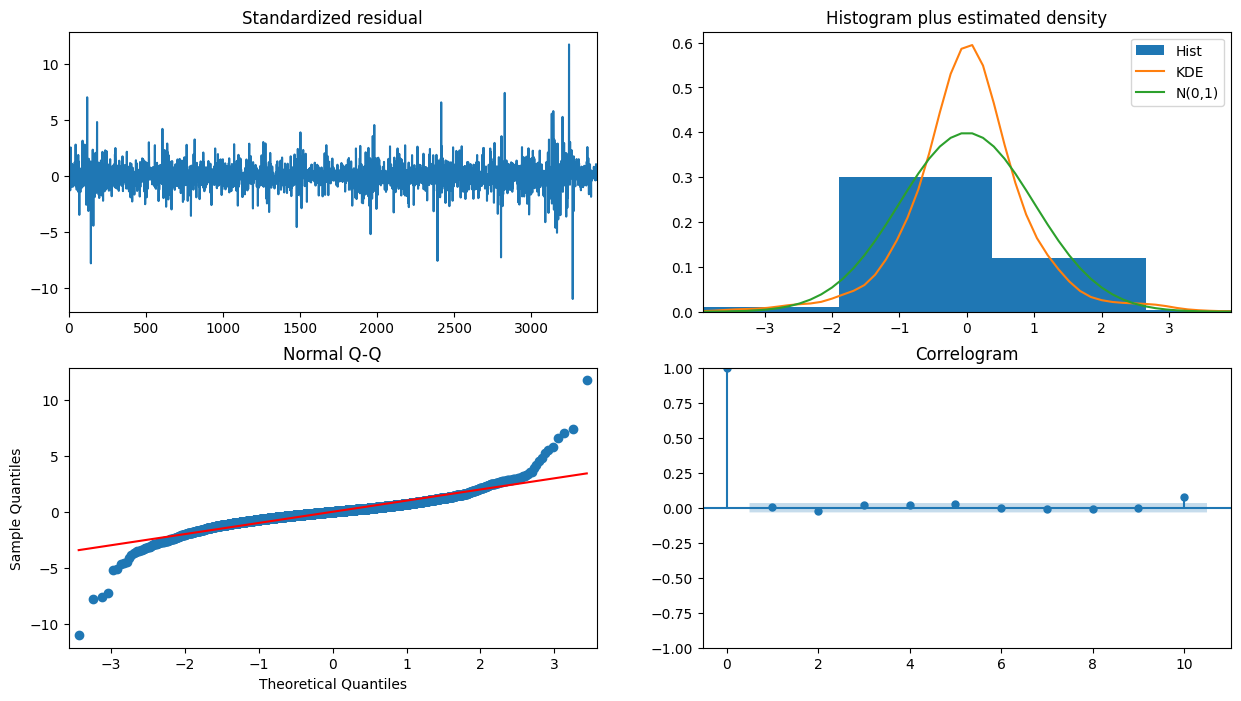

In [12]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',
                      max_p=3, max_q=3, 
                      m=1,              
                      d=None,           
                      seasonal=False,   
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

## Test residual autocorrelation

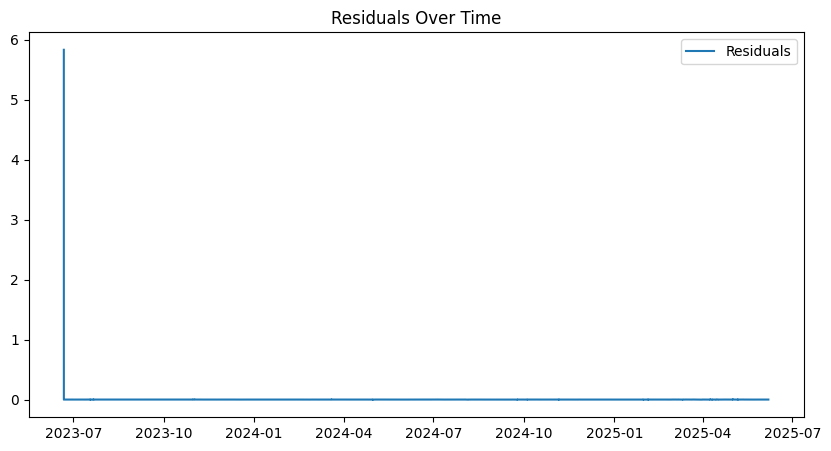

In [13]:
residuals = model_autoARIMA.resid()
plt.figure(figsize=(10,5))
plt.plot(residuals, label="Residuals")
plt.legend()
plt.title("Residuals Over Time")
plt.show()

Ljung-Box Test Hypothesis test
* Null Hypothesis: - The residuals are independently distributed (i.e., no autocorrelation).
* Alternative: The residuals are not independent (i.e., they're autocorrelated)

In [14]:
from statsmodels.stats.diagnostic import acorr_ljungbox

ljung_box_results = acorr_ljungbox(residuals, lags=[1], return_df=True)
print(ljung_box_results)

    lb_stat  lb_pvalue
1  0.000179   0.989336


# Fit Model with Optimal Parameters

In [16]:
best_p, best_d, bestq = model_autoARIMA.order
arima_fitted = ARIMA(train_data, order=(best_p,best_d,bestq)).fit()
print(arima_fitted.summary())

c:\Users\billy\anaconda3\envs\stock_predictions\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\billy\anaconda3\envs\stock_predictions\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\billy\anaconda3\envs\stock_predictions\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:        Rolling_Log_Avg   No. Observations:                 3429
Model:                 ARIMA(1, 1, 0)   Log Likelihood               22554.764
Date:                Fri, 13 Jun 2025   AIC                         -45105.528
Time:                        23:08:02   BIC                         -45093.248
Sample:                             0   HQIC                        -45101.141
                               - 3429                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9487      0.004    224.357      0.000       0.940       0.957
sigma2      1.128e-07   9.73e-10    115.905      0.000    1.11e-07    1.15e-07
Ljung-Box (L1) (Q):                   0.23   Jarque-

c:\Users\billy\anaconda3\envs\stock_predictions\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


c:\Users\billy\anaconda3\envs\stock_predictions\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\billy\anaconda3\envs\stock_predictions\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


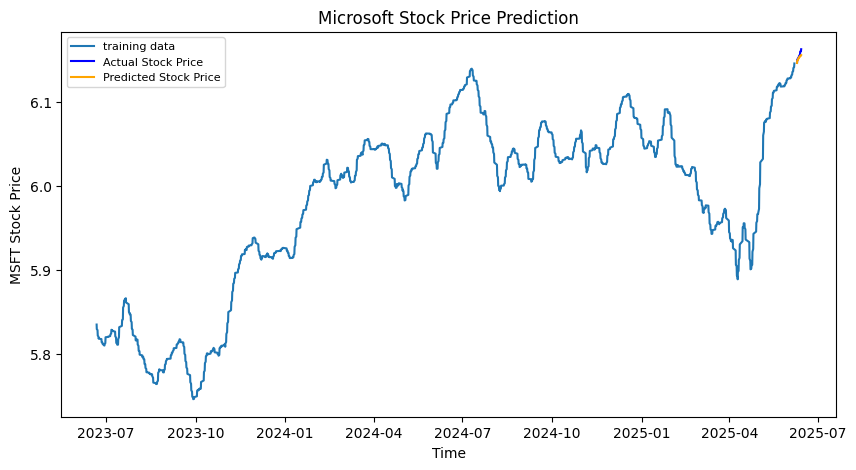

In [17]:
forecast = arima_fitted.forecast(steps=len(test_data))
plt.figure(figsize=(10,5))
plt.plot(train_data.index, train_data,  label='training data')
plt.plot(test_data.index, test_data, color = 'blue', label='Actual Stock Price')
plt.plot(test_data.index, forecast, color = 'orange',label='Predicted Stock Price')
plt.title('Microsoft Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('MSFT Stock Price')
plt.legend(loc='upper left', fontsize=8)
#plt.savefig("3mo.png", dpi=300, bbox_inches="tight")
plt.show()

In [19]:
print("Mean Squared Error:", mean_squared_error(test_data, forecast))
print("Root Mean Square Error:", np.sqrt(mean_squared_error(test_data, forecast)))
print("Mean Absolute Error:", mean_absolute_error(test_data, forecast))
print("Mean Absolute Percentage Error:", mean_absolute_percentage_error(test_data, forecast))

Mean Squared Error: 1.1121224185047846e-05
Root Mean Square Error: 0.0033348499494051972
Mean Absolute Error: 0.002573387624130723
Mean Absolute Percentage Error: 0.00041781418410267


In [86]:
previous_values = np.exp(test_data[-2:].values.flatten())
forecast = model_autoARIMA.predict(n_periods=1, X=test_data[-2:].values.reshape(1, -1)).iloc[0]
forecast_price = np.exp(forecast)

data = {
    "datetime": [test_data.index[-2], test_data.index[-1], "Forecasted Next Hour"],
    "close_price": [previous_values[0], previous_values[1], forecast_price]
}

df_forecast = pd.DataFrame(data)
df_forecast

c:\Users\billy\anaconda3\envs\stock_predictions\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\billy\anaconda3\envs\stock_predictions\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\billy\anaconda3\envs\stock_predictions\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


,datetime,close_price
0,2025-06-13 14:30:00-04:00,474.829414
1,2025-06-13 15:30:00-04:00,475.058291
2,Forecasted Next Hour,467.335966


In [20]:
metrics = {
"MSE": mean_squared_error(test_data, forecast), 
"RMSE": np.sqrt(mean_squared_error(test_data, forecast)),
"MAE": mean_absolute_error(test_data, forecast), 
"MAPE": mean_absolute_percentage_error(test_data, forecast)
}
#df_metrics = pd.DataFrame(metrics, index=[0])
#df_metrics.to_csv('3mo_MSFT_metrics.csv', index=False)
